In [2]:
# Do not edit this cell.

import re
from datetime import datetime, timedelta
from viresclient import SwarmRequest
from matplotlib import pyplot as plt
from numpy import asarray, nan, logical_or, nonzero

RE_ISO_8601_DATETIME = re.compile(
    r"^(\d{4,4})-(\d{2,2})-(\d{2,2})(?:"
    r"T(\d{2,2}):(\d{2,2})"
    r"(?::(\d{2,2})(?:[.,](\d{0,6})\d*)?)?Z?)?$"
)

def parse_utc_datetime(value, tz_local=None):
    """ Parse an ISO 8601 UTC date-time value. """
    match = RE_ISO_8601_DATETIME.match(value)
    if not match:
        raise ValueError("Invalid date-time input!")
    year, month, day, hour, minute, sec, usec = match.groups()
    return datetime(
        int(year), int(month), int(day or 0),
        int(hour or 0), int(minute or 0), int(sec or 0),
        int(((usec or '') + '000000')[:6])
    )

Can't download new leap second table
Can't find leap second table.  Using one built into code.
Last leap second in built in table is on Jan 01 2017. 


[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

start time: 2016-01-01T00:00:00Z
end time:   2016-01-01T23:59:59.999999Z
['F', 'dF_AOCS', 'dF_other', 'F_error', 'B_VFM', 'B_NEC', 'dB_Sun', 'dB_AOCS', 'dB_other', 'B_error', 'q_NEC_CRF', 'Att_error', 'Flags_F', 'Flags_B', 'Flags_q', 'Flags_Platform', 'ASM_Freq_Dev']
['Timestamp', 'Latitude', 'Longitude', 'Radius', 'Spacecraft', 'SyncStatus', 'Kp', 'Dst', 'IMF_BY_GSM', 'IMF_BZ_GSM', 'IMF_V', 'F10_INDEX', 'OrbitSource', 'OrbitNumber', 'AscendingNodeTime', 'AscendingNodeLongitude', 'QDLat', 'QDLon', 'QDBasis', 'MLT', 'SunDeclination', 'SunHourAngle', 'SunRightAscension', 'SunAzimuthAngle', 'SunZenithAngle', 'SunLongitude', 'SunVector', 'DipoleAxisVector', 'NGPLatitude', 'NGPLongitude', 'DipoleTiltAngle', 'UpwardCurrent', 'TotalCurrent', 'DivergenceFreeCurrentFunction', 'F_AMPS', 'B_NEC_AMPS']


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:04, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.454MB)


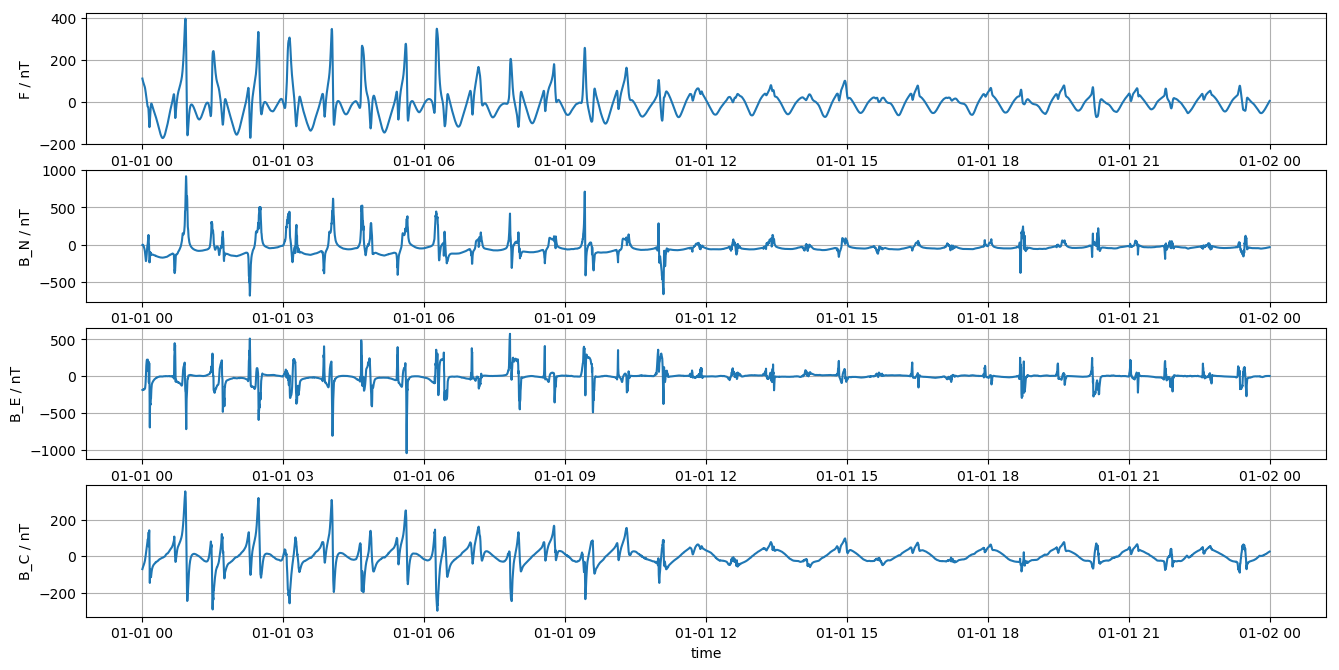

In [10]:
###################################################################################
# set the parameters and press Ctrl-ENTER

collection = "SW_OPER_MAGA_LR_1B" # or "SW_OPER_MAGB_LR_1B" or "SW_OPER_MAGC_LR_1B"
start = "2016-01-01" # included
end = "2016-01-02" # not included
samplig = "PT15S" # set to None to use the original sampling

###################################################################################
# data request
start_time = parse_utc_datetime(start)
end_time = max(start_time, parse_utc_datetime(end) - timedelta(microseconds=1))

print("start time: %sZ" % start_time.isoformat())
print("end time:   %sZ" % end_time.isoformat())

request = SwarmRequest(url="https://staging.viresdisc.vires.services/openows")

print(request.available_measurements(collection="MAG"))
print(request.available_auxiliaries())

request.set_collection(collection)
request.set_products(
    measurements=["B_NEC", "F", "Flags_B", "Flags_F", "Flags_q"],
    auxiliaries=['MLT'],
    models=["CHAOS-6-Combined"],
    residuals=True,
    sampling_step=samplig
)
data = request.get_between(start_time=start_time, end_time=end_time)

# data extraction and visulaization
ds = data.as_xarray()

time = asarray(ds["Timestamp"])
res_b_n = asarray(ds["B_NEC_res_CHAOS-6-Combined"][..., 0])
res_b_e = asarray(ds["B_NEC_res_CHAOS-6-Combined"][..., 1])
res_b_c = asarray(ds["B_NEC_res_CHAOS-6-Combined"][..., 2])
res_f = asarray(ds["F_res_CHAOS-6-Combined"])

# mask invalid measurements
mask_invalid_b_nec, = logical_or(
    asarray(ds["Flags_B"]) == 255,
    asarray(ds["Flags_q"]) == 255
).nonzero()
res_b_n[mask_invalid_b_nec] = nan
res_b_e[mask_invalid_b_nec] = nan
res_b_c[mask_invalid_b_nec] = nan

mask_invalid_f, = (asarray(ds["Flags_F"]) == 255).nonzero()
res_f[mask_invalid_f] = nan

# data visualization
fig=plt.figure(figsize=(16, 8), dpi= 100)

def plot(sp, x, y, l):
    plt.subplot(sp)
    plt.plot(x, y)
    plt.xlabel("time")
    plt.ylabel("%s / nT" % l)
    plt.grid()

plot(411, time, res_f, 'F')
plot(412, time, res_b_n, 'B_N')
plot(413, time, res_b_e, 'B_E')
plot(414, time, res_b_c, 'B_C')

plt.show()